In [1]:
# First, let's see what we can import
import sys
import decontx
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt



def create_test_data(n_genes=500, n_cells=200, n_empty=1000, contamination=0.1, seed=42):
    """Create simple synthetic data for testing."""
    np.random.seed(seed)

    # Create true expression for 5 cell types
    n_types = 5
    cells_per_type = n_cells // n_types
    true_counts = np.zeros((n_genes, n_cells))

    # Each cell type expresses different genes
    for cell_type in range(n_types):
        start_cell = cell_type * cells_per_type
        end_cell = min(start_cell + cells_per_type, n_cells)

        # High expression for marker genes
        marker_genes = range(cell_type * 20, (cell_type + 1) * 20)
        for cell in range(start_cell, end_cell):
            true_counts[list(marker_genes), cell] = np.random.poisson(20, 20)
            # Low background
            other_genes = list(set(range(n_genes)) - set(marker_genes))
            true_counts[other_genes, cell] = np.random.poisson(0.5, len(other_genes))

    # Create soup profile (average of all cells)
    soup_profile = np.mean(true_counts, axis=1)
    soup_profile = soup_profile / soup_profile.sum()

    # Add contamination
    observed = true_counts.copy()
    for cell in range(n_cells):
        cell_total = true_counts[:, cell].sum()
        contam_counts = np.random.poisson(soup_profile * cell_total * contamination)
        observed[:, cell] += contam_counts

    # Create empty droplets
    empty_counts = np.zeros((n_genes, n_empty))
    for i in range(n_empty):
        n_umis = np.random.poisson(10)  # Low UMI counts
        if n_umis > 0:
            empty_counts[:, i] = np.random.multinomial(n_umis, soup_profile)

    # Combine for raw matrix
    raw = np.hstack([empty_counts, observed])

    return {
        'raw': sp.csr_matrix(raw),
        'filtered': sp.csr_matrix(observed),
        'true': sp.csr_matrix(true_counts),
        'genes': [f"Gene_{i:04d}" for i in range(n_genes)],
        'cells': [f"Cell_{i:04d}" for i in range(n_cells)],
        'contamination': contamination,
        'cell_types': np.repeat(range(n_types), cells_per_type)[:n_cells]
    }

# Create test data
data = create_test_data(n_genes=300, n_cells=100, contamination=0.15, seed=42)
print(f"Created data: {data['raw'].shape[0]} genes, {data['raw'].shape[1]} droplets")
print(f"Filtered: {data['filtered'].shape[1]} cells")
print(f"True contamination: {data['contamination']:.1%}")

C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created data: 300 genes, 1100 droplets
Filtered: 100 cells
True contamination: 15.0%


In [2]:
# Clean imports now
from decontx import decontx, simulate_contamination
import anndata as adata_module
import pandas as pd
import numpy as np


print("✓ Successfully imported decontx functions")

✓ Successfully imported decontx functions


In [3]:
# Create AnnData object from your test data
adata = adata_module.AnnData(
    X=data['filtered'].T,  # AnnData expects cells x genes
    var=pd.DataFrame(index=data['genes']),
    obs=pd.DataFrame(index=data['cells'])
)

# Add cell type info
adata.obs['cell_type'] = data['cell_types']

print(f"Created AnnData: {adata.shape} (cells x genes)")
print(f"Cell types: {adata.obs['cell_type'].unique()}")
print(f"Data type: {type(adata.X)}")

Created AnnData: (100, 300) (cells x genes)
Cell types: [0 1 2 3 4]
Data type: <class 'scipy.sparse._csc.csc_matrix'>


In [4]:
# Very basic decontx test - expect this to break early!
try:
    print("Running basic decontx...")
    
    result = decontx(
        adata, 
        copy=True,
        verbose=True,
        max_iter=5,  # Very short for testing
        seed=42
    )
    
    print("🎉 It worked! (surprising)")
    print(f"Result shape: {result.shape}")
    
except Exception as e:
    print(f"💥 Expected error: {e}")
    
    # Show just the error type and message, not full traceback yet
    import traceback
    print(f"Error type: {type(e).__name__}")
    print("Last few lines of traceback:")
    tb_lines = traceback.format_exc().split('\n')
    for line in tb_lines[-6:]:
        if line.strip():
            print(f"  {line}")



Running basic decontx...
2025-09-04 10:57:51 --------------------------------------------------
2025-09-04 10:57:51 Starting DecontX
2025-09-04 10:57:51 --------------------------------------------------
2025-09-04 10:57:51 .. Generating UMAP and estimating cell types


C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\anndata\_core\anndata.py:633: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
C:\Users\nruff\PycharmProjects\decontx-python\decontx\core.py:268: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata_temp.X = X_norm
C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2025-09-04 10:57:59 .... Generated 5 clusters using DBSCAN (eps=1.0)
2025-09-04 10:57:59 .... Using 5 cell clusters
2025-09-04 10:57:59 .. Processing 100 cells and 300 genes
2025-09-04 10:57:59 .... Estimating contamination
2025-09-04 10:58:00 ...... Mean contamination: 25.78%
2025-09-04 10:58:00 ...... Median contamination: 25.75%
2025-09-04 10:58:00 ...... Range: 19.97% - 30.15%
2025-09-04 10:58:00 ...... Cells >50% contaminated: 0
2025-09-04 10:58:00 ...... Converged in 0 likelihood evaluations
2025-09-04 10:58:00 .. Storing results
2025-09-04 10:58:00 .... Stored decontaminated counts in .layers['decontX_counts']
2025-09-04 10:58:00 .... Stored contamination estimates in .obs['decontX_contamination']
2025-09-04 10:58:00 --------------------------------------------------
2025-09-04 10:58:00 Completed DecontX
2025-09-04 10:58:00 --------------------------------------------------
🎉 It worked! (surprising)
Result shape: (100, 300)


In [5]:
# Check the returned result object, not the original adata
print("Results in returned object:")
print(f"Layers: {list(result.layers.keys())}")
print(f"Obs columns: {list(result.obs.columns)}")

# Check for contamination estimates
if 'decontX_contamination' in result.obs:
    print(f"Contamination range: {result.obs['decontX_contamination'].min():.1%} - {result.obs['decontX_contamination'].max():.1%}")
    print(f"Mean contamination: {result.obs['decontX_contamination'].mean():.1%}")

# Check for decontaminated counts
if 'decontX_counts' in result.layers:
    print(f"Decontaminated matrix shape: {result.layers['decontX_counts'].shape}")
    print(f"Original sum: {adata.X.sum():.0f}")
    print(f"Decontaminated sum: {result.layers['decontX_counts'].sum():.0f}")

Results in returned object:
Layers: ['decontX_counts']
Obs columns: ['cell_type', 'decontX_contamination', 'decontX_clusters']
Contamination range: 20.0% - 30.2%
Mean contamination: 25.8%
Decontaminated matrix shape: (100, 300)
Original sum: 62325
Decontaminated sum: 46659


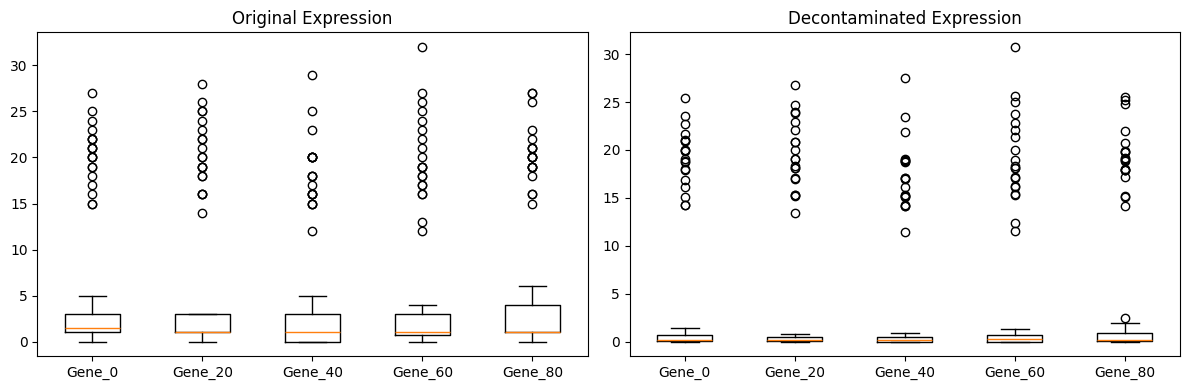

In [6]:
# Let's compare original vs decontaminated
import matplotlib.pyplot as plt

# Check a few marker genes
marker_genes = [f"Gene_{i:04d}" for i in [0, 20, 40, 60, 80]]  # One from each cell type
gene_idx = [result.var_names.get_loc(g) for g in marker_genes if g in result.var_names]

if gene_idx:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original expression
    axes[0].boxplot([result.X[:, i].toarray().flatten() for i in gene_idx])
    axes[0].set_title("Original Expression")
    axes[0].set_xticklabels([f"Gene_{i*20}" for i in range(len(gene_idx))])
    
    # Decontaminated expression  
    axes[1].boxplot([result.layers['decontX_counts'][:, i] for i in gene_idx])
    axes[1].set_title("Decontaminated Expression")
    axes[1].set_xticklabels([f"Gene_{i*20}" for i in range(len(gene_idx))])
    
    plt.tight_layout()
    plt.show()

In [7]:
# Complete Python vs R decontX comparison
import rpy2.robjects as ro
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as adata_module
from decontx import decontx

print("🔬 DecontX Python vs R Comparison")

# 1. Setup R environment
print("\n=== R SETUP ===")
try:
    ro.r('library(decontX)')
    ro.r('library(Matrix)')
    print("✅ R decontX loaded successfully")
except Exception as e:
    print(f"❌ Failed to load R packages: {e}")
    exit()

# 2. Create test data
def create_test_data(n_genes=300, n_cells=100, n_empty=1000, contamination=0.15, seed=42):
    np.random.seed(seed)
    n_types = 5
    cells_per_type = n_cells // n_types
    true_counts = np.zeros((n_genes, n_cells))
    
    for cell_type in range(n_types):
        start_cell = cell_type * cells_per_type
        end_cell = min(start_cell + cells_per_type, n_cells)
        marker_genes = range(cell_type * 20, (cell_type + 1) * 20)
        for cell in range(start_cell, end_cell):
            true_counts[list(marker_genes), cell] = np.random.poisson(20, 20)
            other_genes = list(set(range(n_genes)) - set(marker_genes))
            true_counts[other_genes, cell] = np.random.poisson(0.5, len(other_genes))
    
    soup_profile = np.mean(true_counts, axis=1)
    soup_profile = soup_profile / soup_profile.sum()
    
    observed = true_counts.copy()
    for cell in range(n_cells):
        cell_total = true_counts[:, cell].sum()
        contam_counts = np.random.poisson(soup_profile * cell_total * contamination)
        observed[:, cell] += contam_counts
    
    return {
        'filtered': sp.csr_matrix(observed),
        'genes': [f"Gene_{i:04d}" for i in range(n_genes)],
        'cells': [f"Cell_{i:04d}" for i in range(n_cells)],
        'contamination': contamination,
        'cell_types': np.repeat(range(n_types), cells_per_type)[:n_cells]
    }

# 3. Prepare data
print("\n=== DATA PREPARATION ===")
data = create_test_data(n_genes=300, n_cells=100, contamination=0.15, seed=42)
adata = adata_module.AnnData(
    X=data['filtered'].T,
    var=pd.DataFrame(index=data['genes']),
    obs=pd.DataFrame(index=data['cells'])
)
adata.obs['cell_type'] = data['cell_types']
print(f"✅ Created test data: {adata.shape} (cells x genes)")

# 4. Run Python decontX
print("\n=== PYTHON DECONTX ===")
python_result = decontx(
    adata, 
    copy=True, 
    verbose=False, 
    max_iter=5, 
    seed=42,
    var_genes=2000,  # Match R default
    dbscan_eps=1.0
)
print(f"✅ Python completed: {len(np.unique(python_result.obs['decontX_clusters']))} clusters")

# 5. R decontX function
def run_r_decontx(adata):
    counts_matrix = adata.X.T.toarray().astype(int)
    ro.globalenv['counts_data'] = ro.r.matrix(
        ro.FloatVector(counts_matrix.flatten()), 
        nrow=counts_matrix.shape[0], 
        ncol=counts_matrix.shape[1]
    )
    
    ro.r('''
    set.seed(42)
    r_result <- decontX(x = counts_data, z = NULL, maxIter = 5, seed = 42, verbose = FALSE)
    ''')
    
    return {
        'contamination': np.array(ro.r('as.numeric(r_result$contamination)')),
        'clusters': np.array(ro.r('as.numeric(r_result$z)'))
    }

# 6. Run R decontX
print("\n=== R DECONTX ===")
r_results = run_r_decontx(adata)
print(f"✅ R completed: {len(np.unique(r_results['clusters']))} clusters")

# 7. Compare results
print("\n=== COMPARISON RESULTS ===")
py_contam = python_result.obs['decontX_contamination'].values
r_contam = r_results['contamination']

print(f"True contamination:   {data['contamination']:.1%}")
print(f"Python: Mean={py_contam.mean():.1%}, Std={py_contam.std():.1%}, Clusters={len(np.unique(python_result.obs['decontX_clusters']))}")
print(f"R:      Mean={r_contam.mean():.1%}, Std={r_contam.std():.1%}, Clusters={len(np.unique(r_results['clusters']))}")

correlation = np.corrcoef(py_contam, r_contam)[0, 1]
mae = np.mean(np.abs(py_contam - r_contam))
print(f"Correlation: {correlation:.3f}")
print(f"Mean Absolute Error: {mae:.1%}")

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


🔬 DecontX Python vs R Comparison

=== R SETUP ===

    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ✅ R decontX loaded successfully

=== DATA PREPARATION ===
✅ Created test data: (100, 300) (cells x genes)

=== PYTHON DECONTX ===


C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\anndata\_core\anndata.py:633: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
C:\Users\nruff\PycharmProjects\decontx-python\decontx\core.py:268: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata_temp.X = X_norm
C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Python completed: 5 clusters

=== R DECONTX ===
✅ R completed: 2 clusters

=== COMPARISON RESULTS ===
True contamination:   15.0%
Python: Mean=25.8%, Std=2.2%, Clusters=5
R:      Mean=15.9%, Std=8.4%, Clusters=2
Correlation: 0.097
Mean Absolute Error: 10.6%
